# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftModel, 
    PeftConfig,
)

peft_type = PeftType.LORA
peft_config = LoraConfig(task_type="SEQ_CLS",  r=8, lora_alpha=16, lora_dropout=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


In [6]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# 하이퍼파라미터 설정

In [8]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.0004
        self.batch_size=16
        self.shuffle = True
        self.seed=600
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [10]:
from sklearn.utils import shuffle
trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

# 토크나이저와 모델 정의

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)
model = get_peft_model(model, peft_config).to(device)

model.print_trainable_parameters()
model


trainable params: 2,906,132 || all params: 338,512,916 || trainable%: 0.8584995911943283


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=1024, out_features=1024, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

# 커스텀 데이터셋

In [12]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [13]:
train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                           labels= list(trainset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [14]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [15]:
def validate(epoch, model, loader):
    
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [16]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [17]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.0004)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(train_loader) * cfg.epochs),
    num_training_steps=(len(train_loader) * cfg.epochs),
)

In [18]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, train_loader)

    lr_scheduler.step()

    validate(epoch, model, val_loader)

    # if early_stopping.early_stop:
    #     break
    
    torch.save(model, f'/home/work/CL/final_healthmodel/lora_shuffle_{epoch+1}epoch.pt')
    
    
    # index = index + 1
df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/lora_shuffle.xlsx', index=False)    

    


  0% 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 5.841823577880859
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 0.9029552340507507
1_32_step_정확도 :0.5
Epoch : 1, train_64_step_loss : 1.004148244857788
1_64_step_정확도 :0.5625
Epoch : 1, train_96_step_loss : 0.37734541296958923
1_96_step_정확도 :0.8125
Epoch : 1, train_128_step_loss : 0.644525408744812
1_128_step_정확도 :0.6875
Epoch : 1, train_160_step_loss : 0.8392152786254883
1_160_step_정확도 :0.5625
Epoch:1, train_184_stepLoss:1.0390290160436888
Epoch:1, train_184_stepacc:0.5977477477477477
Epoch:1, train_184_stepacc:0.5977477477477477
Epoch : 1, val_0_step_loss : 0.5630303621292114
1_0_step_정확도 :0.8125
Epoch : 1, val_32_step_loss : 1.0474905967712402
1_32_step_정확도 :0.5
Epoch:1, val_61_stepLoss:0.8558138219579574
Epoch:1, val_61_stepacc:0.6651785714285715
Epoch:1, val_61_stepacc:0.6651785714285715
Validation loss decreased (inf --> 0.855814).  Saving model ...



 10% 1/10 [01:06<09:58, 66.47s/it]

Epoch : 2, train_0_step_loss : 0.49229398369789124
2_0_step_정확도 :0.875
Epoch : 2, train_32_step_loss : 0.5587621331214905
2_32_step_정확도 :0.6875
Epoch : 2, train_64_step_loss : 0.767170786857605
2_64_step_정확도 :0.6875
Epoch : 2, train_96_step_loss : 0.6348305940628052
2_96_step_정확도 :0.75
Epoch : 2, train_128_step_loss : 0.8111518621444702
2_128_step_정확도 :0.5
Epoch : 2, train_160_step_loss : 0.8131891489028931
2_160_step_정확도 :0.75
Epoch:2, train_184_stepLoss:0.8160477891161635
Epoch:2, train_184_stepacc:0.6823198198198198
Epoch:2, train_184_stepacc:0.6823198198198198
Epoch : 2, val_0_step_loss : 0.5946020483970642
2_0_step_정확도 :0.6875
Epoch : 2, val_32_step_loss : 1.0809921026229858
2_32_step_정확도 :0.5
Epoch:2, val_61_stepLoss:0.8476836138194607
Epoch:2, val_61_stepacc:0.6720910138248848
Epoch:2, val_61_stepacc:0.6720910138248848
Validation loss decreased (0.855814 --> 0.847684).  Saving model ...



 20% 2/10 [02:13<08:55, 66.92s/it]

Epoch : 3, train_0_step_loss : 0.8737021684646606
3_0_step_정확도 :0.75
Epoch : 3, train_32_step_loss : 0.44598084688186646
3_32_step_정확도 :0.875
Epoch : 3, train_64_step_loss : 0.5309821963310242
3_64_step_정확도 :0.8125
Epoch : 3, train_96_step_loss : 0.7992185950279236
3_96_step_정확도 :0.5625
Epoch : 3, train_128_step_loss : 0.7565188407897949
3_128_step_정확도 :0.6875
Epoch : 3, train_160_step_loss : 0.7581828236579895
3_160_step_정확도 :0.75
Epoch:3, train_184_stepLoss:0.699243105021683
Epoch:3, train_184_stepacc:0.7256756756756757
Epoch:3, train_184_stepacc:0.7256756756756757
Epoch : 3, val_0_step_loss : 0.546745240688324
3_0_step_정확도 :0.6875
Epoch : 3, val_32_step_loss : 1.2529733180999756
3_32_step_정확도 :0.625
Epoch:3, val_61_stepLoss:0.9339469522237778
Epoch:3, val_61_stepacc:0.6768433179723502
Epoch:3, val_61_stepacc:0.6768433179723502
EarlyStopping counter: 1 out of 3



 30% 3/10 [03:17<07:37, 65.31s/it]

Epoch : 4, train_0_step_loss : 0.8018729090690613
4_0_step_정확도 :0.625
Epoch : 4, train_32_step_loss : 0.23802876472473145
4_32_step_정확도 :1.0
Epoch : 4, train_64_step_loss : 0.5362002849578857
4_64_step_정확도 :0.75
Epoch : 4, train_96_step_loss : 0.2788258194923401
4_96_step_정확도 :0.875
Epoch : 4, train_128_step_loss : 0.3589422106742859
4_128_step_정확도 :0.8125
Epoch : 4, train_160_step_loss : 0.527886688709259
4_160_step_정확도 :0.8125
Epoch:4, train_184_stepLoss:0.5887410697099325
Epoch:4, train_184_stepacc:0.775
Epoch:4, train_184_stepacc:0.775
Epoch : 4, val_0_step_loss : 0.7056753039360046
4_0_step_정확도 :0.8125
Epoch : 4, val_32_step_loss : 1.1737422943115234
4_32_step_정확도 :0.625
Epoch:4, val_61_stepLoss:0.8739042733946154
Epoch:4, val_61_stepacc:0.7033410138248848
Epoch:4, val_61_stepacc:0.7033410138248848
EarlyStopping counter: 2 out of 3



 40% 4/10 [04:21<06:29, 64.99s/it]

Epoch : 5, train_0_step_loss : 0.15744531154632568
5_0_step_정확도 :0.9375
Epoch : 5, train_32_step_loss : 0.29539617896080017
5_32_step_정확도 :0.875
Epoch : 5, train_64_step_loss : 0.4475652873516083
5_64_step_정확도 :0.875
Epoch : 5, train_96_step_loss : 0.2963002920150757
5_96_step_정확도 :0.875
Epoch : 5, train_128_step_loss : 0.2538905441761017
5_128_step_정확도 :0.9375
Epoch : 5, train_160_step_loss : 0.5805614590644836
5_160_step_정확도 :0.75
Epoch:5, train_184_stepLoss:0.47102101920424283
Epoch:5, train_184_stepacc:0.8295045045045045
Epoch:5, train_184_stepacc:0.8295045045045045
Epoch : 5, val_0_step_loss : 0.5448226928710938
5_0_step_정확도 :0.875
Epoch : 5, val_32_step_loss : 0.9941269755363464
5_32_step_정확도 :0.625
Epoch:5, val_61_stepLoss:0.9643971826280316
Epoch:5, val_61_stepacc:0.7001728110599078
Epoch:5, val_61_stepacc:0.7001728110599078
EarlyStopping counter: 3 out of 3



 50% 5/10 [05:24<05:21, 64.40s/it]

Epoch : 6, train_0_step_loss : 0.3518787920475006
6_0_step_정확도 :0.875
Epoch : 6, train_32_step_loss : 0.27580058574676514
6_32_step_정확도 :0.9375
Epoch : 6, train_64_step_loss : 0.3785160481929779
6_64_step_정확도 :0.875
Epoch : 6, train_96_step_loss : 0.3681534230709076
6_96_step_정확도 :0.875
Epoch : 6, train_128_step_loss : 0.547508955001831
6_128_step_정확도 :0.6875
Epoch : 6, train_160_step_loss : 0.10352615267038345
6_160_step_정확도 :1.0
Epoch:6, train_184_stepLoss:0.3911734319216496
Epoch:6, train_184_stepacc:0.8497747747747748
Epoch:6, train_184_stepacc:0.8497747747747748
Epoch : 6, val_0_step_loss : 0.5496465563774109
6_0_step_정확도 :0.875
Epoch : 6, val_32_step_loss : 1.2314250469207764
6_32_step_정확도 :0.6875
Epoch:6, val_61_stepLoss:1.0153380334377289
Epoch:6, val_61_stepacc:0.7138536866359446
Epoch:6, val_61_stepacc:0.7138536866359446
EarlyStopping counter: 4 out of 3



 60% 6/10 [06:28<04:16, 64.01s/it]

Epoch : 7, train_0_step_loss : 0.418997585773468
7_0_step_정확도 :0.8125
Epoch : 7, train_32_step_loss : 0.4648187756538391
7_32_step_정확도 :0.75
Epoch : 7, train_64_step_loss : 0.6149957180023193
7_64_step_정확도 :0.8125
Epoch : 7, train_96_step_loss : 0.41253525018692017
7_96_step_정확도 :0.875
Epoch : 7, train_128_step_loss : 0.6734949946403503
7_128_step_정확도 :0.875
Epoch : 7, train_160_step_loss : 0.023480737581849098
7_160_step_정확도 :1.0
Epoch:7, train_184_stepLoss:0.3042801092001232
Epoch:7, train_184_stepacc:0.8931306306306306
Epoch:7, train_184_stepacc:0.8931306306306306
Epoch : 7, val_0_step_loss : 0.5476107001304626
7_0_step_정확도 :0.875
Epoch : 7, val_32_step_loss : 1.2977070808410645
7_32_step_정확도 :0.6875
Epoch:7, val_61_stepLoss:0.99028645960554
Epoch:7, val_61_stepacc:0.7269585253456221
Epoch:7, val_61_stepacc:0.7269585253456221
EarlyStopping counter: 5 out of 3



 70% 7/10 [07:31<03:11, 63.76s/it]

Epoch : 8, train_0_step_loss : 0.0450185127556324
8_0_step_정확도 :1.0
Epoch : 8, train_32_step_loss : 0.3088394105434418
8_32_step_정확도 :0.875
Epoch : 8, train_64_step_loss : 0.2030695527791977
8_64_step_정확도 :0.875
Epoch : 8, train_96_step_loss : 0.4532814025878906
8_96_step_정확도 :0.875
Epoch : 8, train_128_step_loss : 0.13045990467071533
8_128_step_정확도 :1.0
Epoch : 8, train_160_step_loss : 0.1614382416009903
8_160_step_정확도 :0.9375
Epoch:8, train_184_stepLoss:0.24708728164031699
Epoch:8, train_184_stepacc:0.9152027027027027
Epoch:8, train_184_stepacc:0.9152027027027027
Epoch : 8, val_0_step_loss : 0.8144076466560364
8_0_step_정확도 :0.875
Epoch : 8, val_32_step_loss : 1.18643319606781
8_32_step_정확도 :0.5625
Epoch:8, val_61_stepLoss:1.053613838409224
Epoch:8, val_61_stepacc:0.7206221198156683
Epoch:8, val_61_stepacc:0.7206221198156683
EarlyStopping counter: 6 out of 3



 80% 8/10 [08:35<02:07, 63.77s/it]

Epoch : 9, train_0_step_loss : 0.0728139579296112
9_0_step_정확도 :1.0
Epoch : 9, train_32_step_loss : 0.023651091381907463
9_32_step_정확도 :1.0
Epoch : 9, train_64_step_loss : 0.0775563046336174
9_64_step_정확도 :0.9375
Epoch : 9, train_96_step_loss : 0.012764891609549522
9_96_step_정확도 :1.0
Epoch : 9, train_128_step_loss : 0.0764077752828598
9_128_step_정확도 :0.9375
Epoch : 9, train_160_step_loss : 0.5190796256065369
9_160_step_정확도 :0.8125
Epoch:9, train_184_stepLoss:0.19630081563734927
Epoch:9, train_184_stepacc:0.9331081081081081
Epoch:9, train_184_stepacc:0.9331081081081081
Epoch : 9, val_0_step_loss : 1.042912244796753
9_0_step_정확도 :0.8125
Epoch : 9, val_32_step_loss : 1.7750531435012817
9_32_step_정확도 :0.5625
Epoch:9, val_61_stepLoss:1.2395417370623159
Epoch:9, val_61_stepacc:0.7128456221198156
Epoch:9, val_61_stepacc:0.7128456221198156
EarlyStopping counter: 7 out of 3



 90% 9/10 [09:39<01:03, 63.90s/it]

Epoch : 10, train_0_step_loss : 0.13455820083618164
10_0_step_정확도 :0.9375
Epoch : 10, train_32_step_loss : 0.11312311142683029
10_32_step_정확도 :0.9375
Epoch : 10, train_64_step_loss : 0.30248376727104187
10_64_step_정확도 :0.9375
Epoch : 10, train_96_step_loss : 0.25365957617759705
10_96_step_정확도 :0.875
Epoch : 10, train_128_step_loss : 0.1339104026556015
10_128_step_정확도 :0.9375
Epoch : 10, train_160_step_loss : 0.025321204215288162
10_160_step_정확도 :1.0
Epoch:10, train_184_stepLoss:0.18919903296171814
Epoch:10, train_184_stepacc:0.9347972972972973
Epoch:10, train_184_stepacc:0.9347972972972973
Epoch : 10, val_0_step_loss : 0.5065388083457947
10_0_step_정확도 :0.8125
Epoch : 10, val_32_step_loss : 2.0206966400146484
10_32_step_정확도 :0.625
Epoch:10, val_61_stepLoss:1.376514793403687
Epoch:10, val_61_stepacc:0.7118375576036866
Epoch:10, val_61_stepacc:0.7118375576036866
EarlyStopping counter: 8 out of 3


100% 10/10 [10:42<00:00, 64.25s/it]


In [19]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.039029,0.855814,0.597748,0.665179
1,2,0.816048,0.847684,0.682320,0.672091
2,3,0.699243,0.933947,0.725676,0.676843
3,4,0.588741,0.873904,0.775000,0.703341
4,5,0.471021,0.964397,0.829505,0.700173
5,6,0.391173,1.015338,0.849775,0.713854
6,7,0.304280,0.990286,0.893131,0.726959
7,8,0.247087,1.053614,0.915203,0.720622
8,9,0.196301,1.239542,0.933108,0.712846
9,10,0.189199,1.376515,0.934797,0.711838


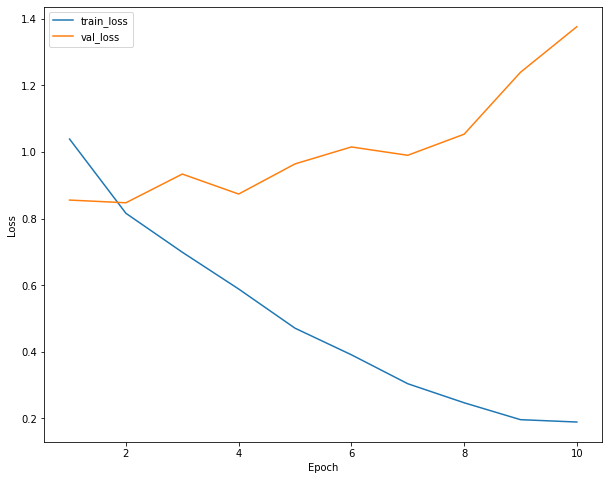

In [20]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df1['epoch'],df1['train_loss'],label='train_loss')
plt.plot(df1['epoch'],df1['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

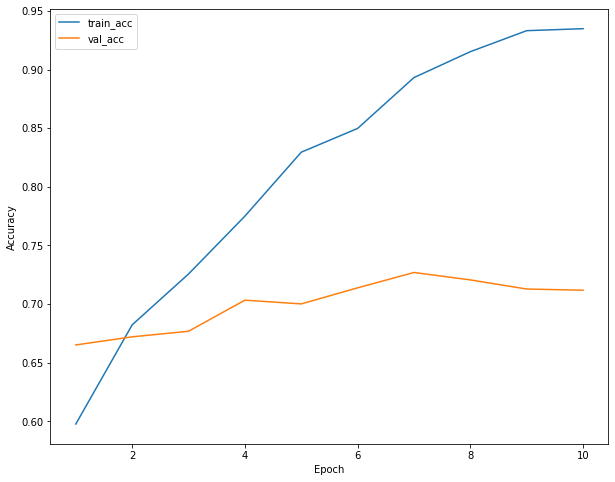

In [21]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(df1['epoch'],df1['train_acc'],label='train_acc')
plt.plot(df1['epoch'],df1['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 2번 도메인까지 학습한뒤 평가(정렬된거기준)

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(11) :
    save_path = f"/home/work/CL/final_healthmodel/lora_shuffle_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:08,  7.57it/s]


test_61_stepLoss:0.8020986364253105
test_61_stepacc:0.6895161290322581
1 (0.8020986364253105, 0.6895161290322581)


62it [00:08,  7.57it/s]


test_61_stepLoss:0.8309270936635232
test_61_stepacc:0.6693548387096774
2 (0.8309270936635232, 0.6693548387096774)


62it [00:08,  7.50it/s]


test_61_stepLoss:0.8438172681677726
test_61_stepacc:0.6985887096774194
3 (0.8438172681677726, 0.6985887096774194)


62it [00:08,  7.56it/s]


test_61_stepLoss:0.8372630318326335
test_61_stepacc:0.7016129032258065
4 (0.8372630318326335, 0.7016129032258065)


62it [00:08,  7.61it/s]


test_61_stepLoss:0.9015427296680789
test_61_stepacc:0.7016129032258065
5 (0.9015427296680789, 0.7016129032258065)


62it [00:08,  7.59it/s]


test_61_stepLoss:0.9478518145699655
test_61_stepacc:0.7036290322580645
6 (0.9478518145699655, 0.7036290322580645)


62it [00:08,  7.56it/s]


test_61_stepLoss:0.9627126382002907
test_61_stepacc:0.7258064516129032
7 (0.9627126382002907, 0.7258064516129032)


62it [00:08,  7.55it/s]


test_61_stepLoss:1.0416877115926435
test_61_stepacc:0.7086693548387096
8 (1.0416877115926435, 0.7086693548387096)


62it [00:08,  7.52it/s]


test_61_stepLoss:1.1550457674649455
test_61_stepacc:0.7207661290322581
9 (1.1550457674649455, 0.7207661290322581)


62it [00:08,  7.54it/s]


test_61_stepLoss:1.2861649239015194
test_61_stepacc:0.7116935483870968
10 (1.2861649239015194, 0.7116935483870968)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/lora_shuffle_11epoch.pt'